<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/FastAIDRGrading(EfficientNet_%2B_BenPreprocess).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !pip install fastai==1.0.42

In [3]:
import os
 
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt
import cv2
 
from sklearn.model_selection import train_test_split
 
from PIL import Image
 
pd.set_option('display.max_colwidth',1000) # to avoid output truncation

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
print('Make sure cuda is installed:', torch.cuda.is_available())
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cuda is installed: True
Make sure cudnn is enabled: True


In [6]:
# Set seed for all
def seed_everything(seed=1358):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

#Train Data Read

In [7]:
dataset_images_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images"
dataset_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/file1.csv"
 
df = pd.read_csv(dataset_groundtruth_location)
df_ = pd.DataFrame();
df.columns=('ind','Image name','Retinopathy grade')
df['ind'] = df['ind'].astype(str)
df_['path'] = dataset_images_location + '/' + (df['ind']) + ".jpg"
df_['level'] = df['Retinopathy grade']
df = df_

test_df = df[-103:]
df = df[0:-103]
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
#df['level'] = df['level'].astype('int32')
# df.head(10)
print(df)
 
img = cv2.imread(df['path'][1])
print(img.dtype)

                                                                                        path  level
0     /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/34.jpg      3
1    /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/339.jpg      2
2    /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/259.jpg      2
3    /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/230.jpg      2
4    /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/120.jpg      2
..                                                                                       ...    ...
408  /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/137.jpg      0
409  /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/198.jpg      0
410  /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/345.jpg      0


In [8]:
df.head()

,path,level
0,/content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/34.jpg,3
1,/content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/339.jpg,2
2,/content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/259.jpg,2
3,/content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/230.jpg,2
4,/content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/120.jpg,2


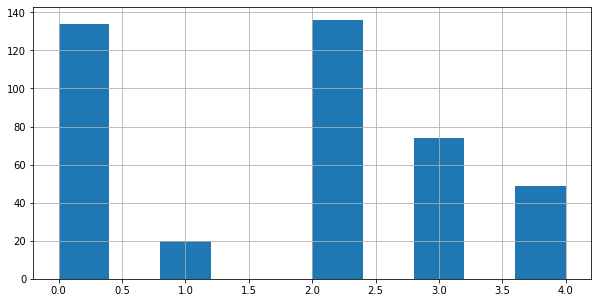

In [9]:
df['level'].hist(figsize = (10, 5))

In [10]:
df.pivot_table(index='level', aggfunc=len)

,path
level,
0,134
1,20
2,136
3,74
4,49


In [11]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df

In [12]:
train_df, val_df = train_test_split(df,test_size=0.2) # Here we will perform an 80%/20% split of the dataset, with stratification to keep similar distribution in validation set

83

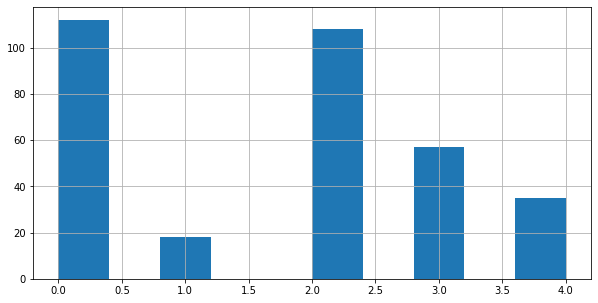

In [13]:
train_df['level'].hist(figsize = (10, 5))
len(val_df)

In [14]:
train_df.pivot_table(index='level', aggfunc=len)

,path
level,
0,112
1,18
2,108
3,57
4,35


New Data Size: 560 Old Size: 330


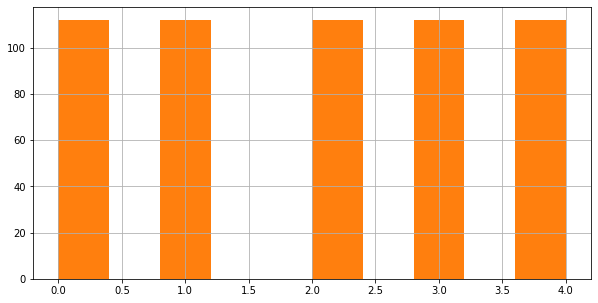

In [15]:
train_df = balance_data(train_df.pivot_table(index='level', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['level'].hist(figsize = (10, 5))

In [16]:
df = pd.concat([train_df,val_df]) #beginning of this dataframe is the oversampled training set, end is the validation set
len(df)
print(df)

                                                                                        path  level
0    /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/401.jpg      1
1    /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/281.jpg      2
2    /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/356.jpg      3
3    /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/301.jpg      1
4    /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/292.jpg      2
..                                                                                       ...    ...
329  /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/139.jpg      0
239   /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/25.jpg      3
389  /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/226.jpg      0


In [17]:
im = Image.open(train_df['path'][1])
width, height = im.size
# im.show
print(width,height)

512 512


In [18]:
bs = 16 #smaller batch size is better for training, but may take longer
sz=224
print(len(train_df))
print(len(val_df))
print(len(df))

560
83
643


In [19]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [20]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
 
data = ImageDataBunch.from_df(path = '/', df = df, ds_tfms = tfms, size = sz, valid_pct = (len(val_df) / len(df)), bs = bs)
data = data.normalize(imagenet_stats)
print(data)

ImageDataBunch;

Train: LabelList (560 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,3,1,2,1
Path: /;

Valid: LabelList (83 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
3,0,4,4,2
Path: /;

Test: None


[0, 1, 2, 3, 4]


(5, 5)

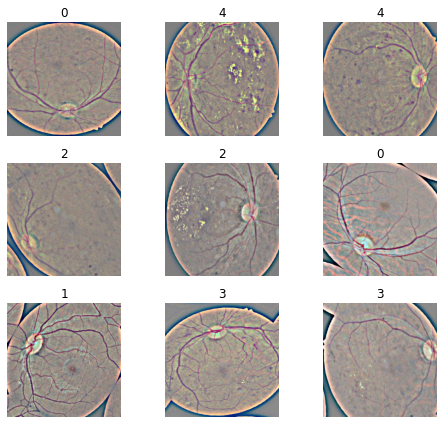

In [21]:
data.show_batch(rows=3, figsize=(7,6))

print(data.classes)
len(data.classes),data.c

#Transfer Learning (EfficientNet)

In [22]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.argmax(y_hat.cpu(),1), y.cpu(), weights='quadratic'),device='cuda:0')

In [23]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=3., reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = ((1 - pt)**self.gamma) * CE_loss
        if self.reduction == 'sum':
            return F_loss.sum()
        elif self.reduction == 'mean':
            return F_loss.mean()

In [24]:
pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=3e362e3fd6786dd6404b45c653e2928f30739695116f941afab1ceefd81bdc57
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [25]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b4')
model._fc = nn.Linear(model._fc.in_features, 5)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4


In [26]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [27]:
import torchvision
# learn_efficient = Learner(data, model, metrics = [accuracy,quadratic_kappa])
learn_efficient = Learner(data, model,
                loss_func=FocalLoss(),
                metrics=[accuracy, quadratic_kappa],
                callback_fns=[BnFreeze]
               )

In [28]:
learn_efficient.split( lambda m: (model._conv_head,) )

Learner(data=ImageDataBunch;

Train: LabelList (560 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,3,1,2,1
Path: /;

Valid: LabelList (83 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
3,0,4,4,2
Path: /;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.0100000000

In [29]:
learn_efficient.freeze()

In [30]:
# learn_efficient.lr_find(start_lr=1e-5, end_lr=1e1, wd=5e-3)
# learn_efficient.recorder.plot(suggestion=True)

In [31]:
learn_efficient.fit_one_cycle(4, max_lr=3e-3, pct_start=0.1, div_factor=10, final_div=30, wd=5e-3, moms=(0.9, 0.8))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,0.578216,0.660120,0.361446,0.500900,01:41
1,0.455585,0.535161,0.421687,0.790087,00:13
2,0.387084,0.338199,0.554217,0.826799,00:13
3,0.334100,0.325380,0.590361,0.841905,00:13


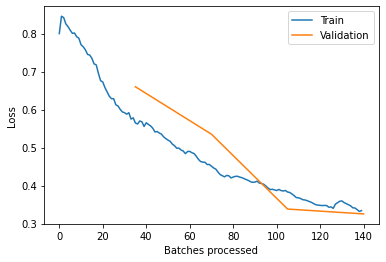

In [32]:
learn_efficient.recorder.plot_losses()

In [33]:
learn_efficient.unfreeze()

In [34]:
learn_efficient.fit_one_cycle(4, max_lr=slice(1e-4, 1e-3), div_factor=50, final_div=100, wd=1e-3, moms=(0.9, 0.8))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,0.292305,0.271518,0.674699,0.867116,00:15
1,0.269905,0.182625,0.795181,0.882806,00:15
2,0.235633,0.176755,0.783133,0.926383,00:15
3,0.200693,0.187905,0.807229,0.890469,00:15


In [35]:
# train all layers
# learn_efficient.fit_one_cycle(cyc_len=15, max_lr=slice(1e-4, 1e-3), pct_start=0, final_div=1000, wd=1e-3, moms=(0.9, 0.8)) # warm restart: pct_start=0

In [36]:
learn_efficient.export('/content/drive/MyDrive/IDRid/Models/EffNet_BenPreprocess_512.pkl')

In [37]:
# learn_efficient.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

In [38]:
# learn_efficient.recorder.plot_losses()

In [39]:
# learn_efficient.save('stage-2-224')

In [40]:
# learn_efficient.save('stage-2-448')

#Progressive Resizing

In [41]:
dataNew = ImageDataBunch.from_df(path = '/', df = df, ds_tfms = tfms, size = sz * 2, valid_pct = (len(val_df) / len(df)), bs = 4)
dataNew = dataNew.normalize(imagenet_stats)

In [42]:
learn_efficient.data = dataNew
dataNew.train_ds[0][0].shape

torch.Size([3, 448, 448])

In [43]:
learn_efficient.freeze()

In [44]:
learn_efficient.fit_one_cycle(4, max_lr=3e-3, pct_start=0.1, div_factor=10, final_div=30, wd=5e-3, moms=(0.9, 0.8))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,0.543036,0.699748,0.554217,0.612269,00:36
1,0.432782,0.431940,0.614458,0.721666,00:36
2,0.334623,0.193091,0.746988,0.774031,00:36
3,0.197167,0.197501,0.734940,0.800803,00:36


In [45]:
learn_efficient.unfreeze()

In [46]:
learn_efficient.fit_one_cycle(4, max_lr=slice(1e-4, 1e-3), div_factor=50, final_div=100, wd=1e-3, moms=(0.9, 0.8))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,0.246470,0.219534,0.746988,0.784664,00:49
1,0.222533,0.251611,0.795181,0.837366,00:49
2,0.183730,0.224328,0.843373,0.831301,00:49
3,0.154375,0.194284,0.843373,0.830290,00:49


In [47]:
learn_efficient.export('/content/drive/MyDrive/IDRid/Models/EffNet_BenPreprocess_512.pkl')

#Checking Results

In [48]:
# learn_efficient = load_learner('/content/drive/MyDrive/IDRid/Models')

In [49]:
# interp = ClassificationInterpretation.from_learner(learn_efficient)

# # losses,idxs = interp.top_losses()

# len(data.valid_ds)==len(losses)==len(idxs)

In [50]:
# interp.plot_top_losses(9, figsize=(15,11))

In [51]:
# interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Testing Data

In [52]:
# test_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set"
# test_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv"

# test_df = pd.read_csv(test_groundtruth_location)
# test_df_ = pd.DataFrame();
# test_df_['path'] = test_images_location + '/' + test_df['Image name'] + ".jpg"
# test_df_['level'] = test_df['Retinopathy grade']
# test_df = test_df_

print(test_df)

                                                                                        path  level
413  /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/413.jpg      4
414  /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/414.jpg      4
415  /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/415.jpg      4
416  /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/416.jpg      4
417  /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/417.jpg      4
..                                                                                       ...    ...
511  /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/511.jpg      0
512  /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/512.jpg      2
513  /content/drive/MyDrive/IDRid/B. Disease Grading/ Ben_Processed Full_Size Images/513.jpg      1


In [53]:
# Create a test set to pass to our learner
test = (ImageList.from_df(path='/', df=test_df))
learn_efficient.data.add_test(test)

In [54]:
# Get predictions
preds1, l1 = learn_efficient.get_preds(DatasetType.Test)
preds2, l2 = learn_efficient.TTA(ds_type=DatasetType.Test)

In [55]:
preds1 = np.array(preds1)
preds2 = np.array(preds2)
print("preds1", preds1.shape)
print("preds2", preds2.shape)

preds1 (103, 5)
preds2 (103, 5)


In [56]:
preds1 = np.argmax(preds1, axis = 1)
preds2 = np.argmax(preds2, axis = 1)
print("preds1", preds1.shape)
print("preds2", preds2.shape)

preds1 (103,)
preds2 (103,)


In [57]:
labels = test_df['level']
labels.shape

(103,)

In [58]:
preds1

array([4, 3, 0, 0, ..., 2, 0, 2, 0])

In [59]:
preds2

array([4, 3, 0, 0, ..., 2, 0, 2, 0])

In [60]:
from sklearn.metrics import accuracy_score
print("preds1 => accuracy:", accuracy_score(labels, preds1))
print("preds2(with TTA) => accuracy:", accuracy_score(labels, preds2))

preds1 => accuracy: 0.6213592233009708
preds2(with TTA) => accuracy: 0.6601941747572816


In [61]:
from sklearn.metrics import cohen_kappa_score
print("preds1 => quadratic_weighted_kappa:", cohen_kappa_score(labels, preds1, weights = "quadratic"));
print("preds2(with TTA) => quadratic_weighted_kappa:", cohen_kappa_score(labels, preds2, weights = "quadratic"));

preds1 => quadratic_weighted_kappa: 0.6562462484093255
preds2(with TTA) => quadratic_weighted_kappa: 0.682923282026421


preds1 => Confusion Matrix
[[28  1  5  0  0]
 [ 4  1  0  0  0]
 [ 5  0 18  8  1]
 [ 2  0  3 13  1]
 [ 3  0  2  4  4]]


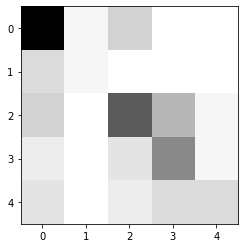

In [62]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, preds1) 
print("preds1 => Confusion Matrix")
print(cm)
plt.imshow(cm, cmap = 'binary')

preds2(with TTA) => Confusion Matrix
[[27  1  6  0  0]
 [ 5  0  0  0  0]
 [ 4  0 22  5  1]
 [ 1  1  2 14  1]
 [ 3  0  1  4  5]]


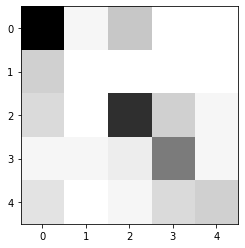

In [63]:
cm = confusion_matrix(labels, preds2) 
print("preds2(with TTA) => Confusion Matrix")
print(cm)
plt.imshow(cm, cmap = 'binary')

In [64]:
# TTA is easy - use .TTA() in place of .get_preds()
# preds_tta, labels_tta = learn.TTA(ds_type=DatasetType.Test)

In [65]:
# acc_tta = accuracy(preds_tta, labels_tta)
# print(acc_tta)

In [66]:
# test_images = []
# im_size = 224
# for image_path in df['path']:
#     img = cv2.imread(image_path)
#     img = cv2.resize(img, (im_size, im_size));
#     test_images.append(img);

In [67]:
# test_pred = learn.predict_array(test_imgs)
# test_pred = np.argmax(test_pred, axis=1)
# test_pred

In [68]:
# sample for finding quadratic weighted kappa
# from sklearn.metrics import cohen_kappa_score, confusion_matrix
# import numpy as np
# from time import time

# #dataset
# actuals = np.array([4, 4, 3, 4, 4, 0, 1, 1, 2, 1])
# preds   = np.array([0, 4, 1, 0, 4, 0, 1, 1, 2, 1])
# qwk = cohen_kappa_score(actuals, preds, weights="quadratic")
# print(qwk)